## ¿Donde construir un centro de distribución?
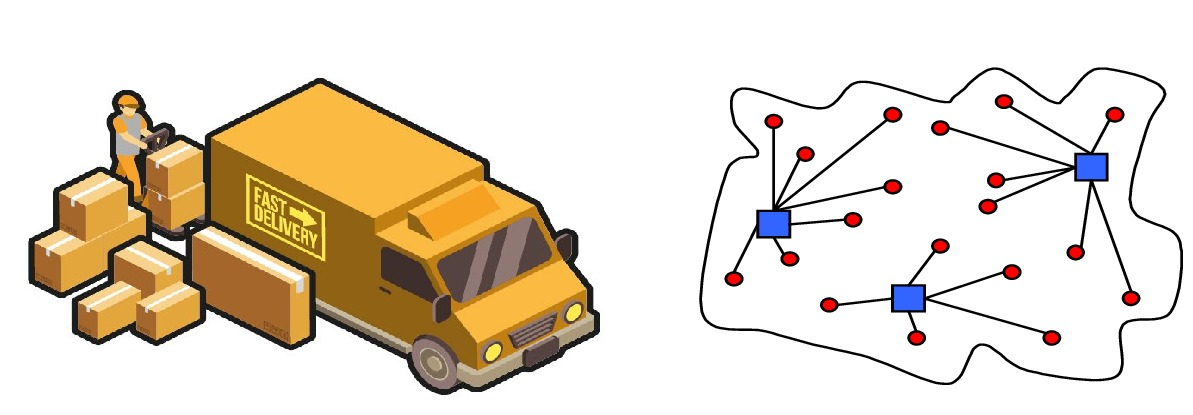

### Situación
Se tinen $m$ clientes y $n$ sitios potenciales para construir distribuidoras y se pretende encontrar el número mínimo de sitios para construir las distribuidoras de manera que se cubra la demanda de todos los clientes y se minimizen costos de construcción y distribución.

**Parametros y variables**

Para $I=\{1,2,...,n\}$ y $J=\{1,2,...,m\}$ se tienen:

- $f_i$ es el costo por construir una distribuidora en i'esimo sitio
- $d_j$ es la demanda del j'esimo cliente
- $K_i$ es la capacidad de envio de la i'esima distribuidora
- $x_{ij}$ es la cantidad enviada del i'esimo centro de distribución al j'esimo cliente
- $c_{ij}$ es el costo por enviar la cantidad $x$ de producto de la i'esima distribuidora al j'esimo cliente
- $y_i$ es una variable binaria que nos dice si una distribuidora se construye en el i'esimo sitio



**Modelo matemático**

Minimizar
$$
z = \sum_{i=1}^n f_i y_i + \sum_{i=1}^n \sum_{j=1}^m c_{ij}x_{ij}
$$

Sujeto a: 
1. Para cada cliente, la cantidad enviada por todas las distribuidoras debe ser mayor o igual que la demanda de dicho cliente

$$
\sum_{i=1}^n x_{ij} \geq d_j
$$

2. Cada distribuidora tiene una capacidad de envio K que no puede ser sobrepasada.
$$
\sum_{j=1}^m x_{ij} \leq K_i y_i
$$

Donde las cantidades $X_{ij}$ enviadas son estrictamente positivas o nulas
$$
x_{ij}\geq 0\ \ , \ \ y_i\in\ \{0,1\}\ \ , \ \ i\in\ I\ y\ \ j\in\ J
$$

**Información del problema**

La siguiente tabla proporciona todos los datos necesarios para resolver el problema:

Cliente $j$ | 1 | 2 | 3 | 4 | 5 | | |
:------:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
**Distribuidora** $i$ | |   |   |   | | $f_i$ | $K_i$ |
1 | 4 | 5 | 6 | 8 | 10 | 1000 | 500 |
2 | 6 | 4 | 3 | 5 | 8  | 1000 | 500 | 
3 | 9 | 7 | 4 | 3 | 4  | 1000 | 500 |
**Demanda** $d_{ij}$| 80 | 270 | 250 | 160 | 180 | | | 

**Implementación del modelo en Python**

In [1]:
# Datos de entrada:
d = {1: 80, 2:270, 3:250, 4:160, 5:180} # demanda por cliente
f = {1:1000, 2:1000, 3:1000} # costo de construcción por distribuidora
K = {1:500, 2:500, 3:500} # Capacidad de cada distribuidora
n = len(K)  ;  m = len(d)

# Costo de enviar el x cantidad de producto de la distribuidora "i" al cliente "j"
c = { (1,1):4, (1,2):5, (1,3):6, (1,4):8, (1,5):10,
      (2,1):6, (2,2):4, (2,3):3, (2,4):5, (2,5):8, 
      (3,1):9, (3,2):7, (3,3):4, (3,4):3, (3,5):4 }

In [2]:
# Importamos el ambiente Pyomo
from pyomo.environ import *

In [3]:
# Creamos el modelo
model = ConcreteModel()

# Creamos los sets que daran dimensión a nuestras variables decisión
model.I = RangeSet(n)
model.J = RangeSet(m)

# Inicializamos los datos como parametros en el ambiente Pyomo
model.d = Param(model.J, initialize = d)
model.f = Param(model.I, initialize = f)
model.K = Param(model.I, initialize = K)
model.c = Param(model.I, model.J, initialize = c)

# Definimos las variables
model.x = Var(model.I, model.J, within=NonNegativeReals)
model.y = Var(model.I, within=Binary)

# Función objetivo
def OB(model):
    return sum(model.f[i]*model.y[i] for i in model.I) + sum(sum(model.c[i,j]*model.x[i,j] for i in model.I) for j in model.J)
model.z = Objective(rule = OB)

# Constricciones
def rule1(model,j):
    return sum(model.x[i,j] for i in model.I) >= model.d[j] 
model.C1 = Constraint(model.J, rule = rule1)

def rule2(model,i):
    return sum(model.x[i,j] for j in model.J) == model.K[i]*model.y[i]
model.C2 = Constraint(model.I, rule = rule2)

In [4]:
# Resolvemos el problema
solver = SolverFactory('glpk')
resultados = solver.solve(model)

In [5]:
# En esta lista se guardaran los indices de los centros abiertos
opened = []

print('Los centros que se abriran son:')
for i in model.I:
    if value(model.y[i]) == 1:
        print('i =',i)
        opened.append(i)
        
print('Los centros que NO se abriran son:')
for i in model.I:
    if value(model.y[i]) != 1:
        print('i =',i)

Los centros que se abriran son:
i = 2
i = 3
Los centros que NO se abriran son:
i = 1


In [8]:
# las cantidades enviadas:
for i in opened:
    for j in model.J:
        print('Del centro',i,' al cliente',j,'-> Xij =',value(model.x[i,j]))

Del centro 2  al cliente 1 -> Xij = 80.0
Del centro 2  al cliente 2 -> Xij = 270.0
Del centro 2  al cliente 3 -> Xij = 150.0
Del centro 2  al cliente 4 -> Xij = 0.0
Del centro 2  al cliente 5 -> Xij = 0.0
Del centro 3  al cliente 1 -> Xij = 0.0
Del centro 3  al cliente 2 -> Xij = 0.0
Del centro 3  al cliente 3 -> Xij = 100.0
Del centro 3  al cliente 4 -> Xij = 220.0
Del centro 3  al cliente 5 -> Xij = 180.0


In [47]:
# Costo total de construcción
print('El costo total es: $',value(model.z))

El costo total es: 5790.0
